In [11]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Exploratory Analysis

In [2]:
%%time
df = pd.read_csv("Crime_cleaned.csv", index_col=0, parse_dates = ['Occurred Date', 'Clearance Date'])

Wall time: 54.3 s


In [48]:
df_18 = df[(df['Occurred Date'] >= '2018-01-01') & (df['Occurred Date'] < '2019-01-01')]

In [13]:
print(df_18['Occurred Date'].max())
print(df_18['Occurred Date'].min())

2018-12-31 00:00:00
2018-01-01 00:00:00


In [14]:
df_18['Month'] = df_18['Occurred Date'].map(lambda x: x.month)

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


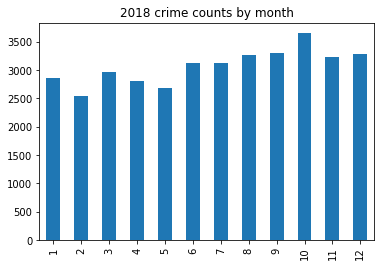

In [18]:
month_count = df_18['Month'].value_counts()
month_count.sort_index().plot(kind='bar', title = "2018 crime counts by month")

# what offense type happens more at night?

In [3]:
len(df['Category Description'].value_counts())

7

In [19]:
df['Occurred Date'].max()

Timestamp('2019-07-20 00:00:00')

In [4]:
catgory = df['Category Description'].value_counts()

In [5]:
# DayNight
def get_day_night(x):
    if (x>2200)or(x<600):
        return('night')
    elif (x>600)and(x<1400):
        return('morning')
    else:
        return('afternoon')
df['DayNight'] = df['Occurred Time'].map(get_day_night)

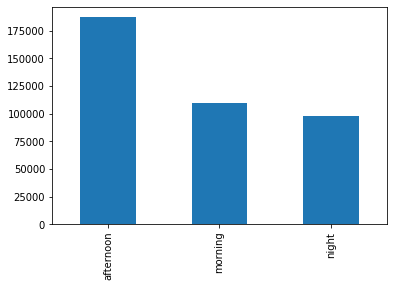

In [6]:
df['DayNight'].value_counts().plot(kind='bar')

In [7]:
catgory = pd.DataFrame(catgory)
cat_night = pd.DataFrame(df[df['DayNight'] == 'night']['Category Description'].value_counts())
cat_mor = pd.DataFrame(df[df['DayNight'] == 'morning']['Category Description'].value_counts())

In [8]:
cat_m = catgory.merge(cat_night, 
                      left_on=catgory.index.values, 
                      right_on=cat_night.index.values, suffixes=['_All', '_night'])
cat_m = cat_m.set_index('key_0')

cat_m.index.name = None

cat_m = cat_m.merge(cat_mor, 
                      left_on=cat_m.index.values, 
                      right_on=cat_mor.index.values, suffixes=['', '_morning'])

cat_m = cat_m.set_index('key_0')

In [9]:
cat_m['night'] = cat_m['Category Description_night']/cat_m['Category Description_All']
cat_m['morning'] = cat_m['Category Description']/cat_m['Category Description_All']
cat_m['afternoon'] = 1 - cat_m['night'] - cat_m['morning']

In [48]:
cat_m[['morning', 'afternoon', 'night']]
cat_m.index.name = 'Crime Type'

Text(0.5, 1, 'Crime activities in a day')

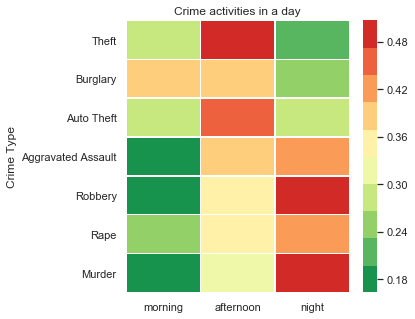

In [49]:
ax = sns.heatmap(cat_m[['morning', 'afternoon', 'night']], linewidths=.5, cmap = sns.color_palette("RdYlGn_r", 10))
ax.set_title("Crime activities in a day")

# which sector has higher close rate

In [127]:
# sector = pd.DataFrame(df['APD Sector'].value_counts().head(10))

# df_clear = df[df['Clearance Status'] != 'N']

# df_clear = pd.DataFrame(df_clear['APD Sector'].value_counts().head(10))

# clear_m = sector.merge(df_clear, left_on = sector.index.values, 
#                        right_on = df_clear.index.values, suffixes=['_all', '_cleared'])

# clear_m = clear_m.set_index('key_0')

# clear_m['Cleared percetage'] = clear_m['APD Sector_cleared']/clear_m['APD Sector_all']

# plt.figure(figsize=(8, 5))
# clear_m['Cleared percetage'].sort_values().plot(kind='bar', title='Case solving rate by APD sector')

# APD sector Violent, non-violent

In [55]:
df.columns

Index(['Incident Number', 'Highest Offense Description',
       'Highest Offense Code', 'Family Violence', 'Occurred Date Time',
       'Occurred Date', 'Occurred Time', 'Report Date Time', 'Report Date',
       'Report Time', 'Location Type', 'Address', 'Zip Code',
       'Council District', 'APD Sector', 'Census Tract', 'Clearance Status',
       'Clearance Date', 'UCR Category', 'Category Description', 'Latitude',
       'Longitude', 'Location', 'DayNight'],
      dtype='object')

In [193]:
df['APD Sector'] = df['APD Sector'].replace(['AD','AP','BA','CH','DA','ED','FR','GE','HE','ID'],
                          ['ADAM','APT','BAKER','CHARLIE','DAVID','EDWARD','FRANK','GEORGE','HENRY','IDA'])

sector_names = ['ADAM','APT','BAKER','CHARLIE','DAVID','EDWARD','FRANK','GEORGE','HENRY','IDA']
df_name = df[df['APD Sector'].map(lambda x: x in sector_names)]
df_name = df_name[df['Occurred Date'] >= '2018-1-1']
df_name = df_name[df_name['Occurred Date'] < '2019-1-1']
# there're some null values in clearance status, we are not counting them. 
# Because the amount is relatively small. and we are not sure if it's solved or not
sec = df_name.groupby(by=['APD Sector', 'Category Description', 'Clearance Status'])['Incident Number'].count()
sec = sec.reset_index()

# C Cleared by Arrest 
# O Cleared by Exception 
# N Not cleared 
sec['Clearance Status'][sec['Clearance Status'] == 'O'] = 'C'

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [194]:
violent = ['Aggravated Assault', 'Murder', 'Rape']
sec['Crime Type'] = 'non-violent'
sec['Crime Type'][sec['Category Description'].map(lambda x: x in violent)] = 'violent'

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


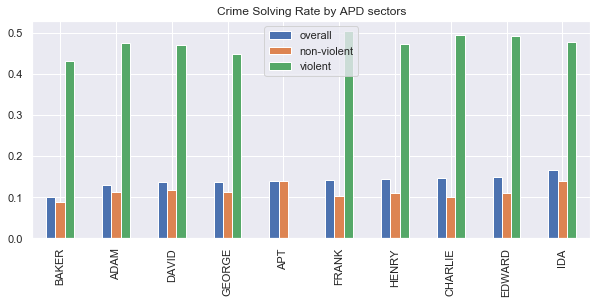

In [195]:
########CN_total
CN = sec.groupby(by = ['APD Sector', 'Clearance Status'])[['Incident Number']].sum().unstack()
# get rid of hierachical column
CN = CN['Incident Number']
CN['total'] = CN['C'] + CN['N']
CN['clearance status'] = CN['C'] / CN['total']
CN_total = CN['clearance status'].sort_values()

########CN_NV
CN = sec[sec['Crime Type'] == 'non-violent'].groupby(by = ['APD Sector', 'Clearance Status'])[['Incident Number']].sum().unstack()
# get rid of hierachical column
CN = CN['Incident Number']
CN['total'] = CN['C'] + CN['N']
CN['clearance status'] = CN['C'] / CN['total']
CN_NV = CN['clearance status'].sort_values()

########CN_V
CN = sec[sec['Crime Type'] == 'violent'].groupby(by = ['APD Sector', 'Clearance Status'])[['Incident Number']].sum().unstack()
# get rid of hierachical column
CN = CN['Incident Number']
CN['total'] = CN['C'] + CN['N']
CN['clearance status'] = CN['C'] / CN['total']
CN_V = CN['clearance status'].sort_values()

########CN_f
CN_f = pd.DataFrame({'overall': CN_total, 'non-violent': CN_NV, 'violent': CN_V}, index=CN_total.index.values)
CN_f.plot(kind='bar', figsize=(10,4), title = 'Crime Solving Rate by APD sectors')

In [197]:
CN_f.overall.mean()

0.13944939091573172

# How long does it take to solve acrime

In [198]:
mask = (df['Clearance Status']=='C') | (df['Clearance Status']=='O')
df_cl = df[mask]
df_cl['Time processing'] = (df_cl['Clearance Date'] - df_cl['Occurred Date']).map(lambda x: x.days)

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [199]:
df_name = df_cl[df_cl['APD Sector'].map(lambda x: x in sector_names)]
df_name = df_name[df['Occurred Date'] >= '2018-1-1']
df_name = df_name[df_name['Occurred Date'] < '2019-1-1']
# there're some null values in clearance status, we are not counting them. 
# Because the amount is relatively small. and we are not sure if it's solved or not
sec = df_name.groupby(by=['APD Sector', 'Category Description'])['Time processing'].mean()
sec = sec.reset_index()
violent = ['Aggravated Assault', 'Murder', 'Rape']
sec['Crime Type'] = 'non-violent'
sec['Crime Type'][sec['Category Description'].map(lambda x: x in violent)] = 'violent'

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'days')

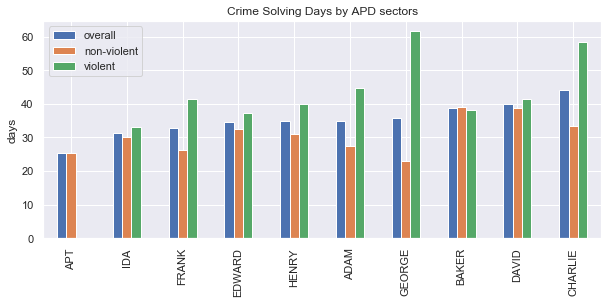

In [200]:
CN_total = sec.groupby(by = ['APD Sector'])['Time processing'].mean().sort_values()
CN_NV = sec[sec['Crime Type'] == 'non-violent'].groupby(by = ['APD Sector'])['Time processing'].mean()
CN_V = sec[sec['Crime Type'] == 'violent'].groupby(by = ['APD Sector'])['Time processing'].mean()

CN_f = pd.DataFrame({'overall': CN_total, 'non-violent': CN_NV, 'violent': CN_V}, index=CN_total.index.values)
ax = CN_f.plot(kind='bar', figsize=(10,4), title = 'Crime Solving Days by APD sectors')
ax.set_ylabel('days')

In [202]:
CN_f.overall.mean()

35.25635968438385

# what type of crime is the most difficult to solve?

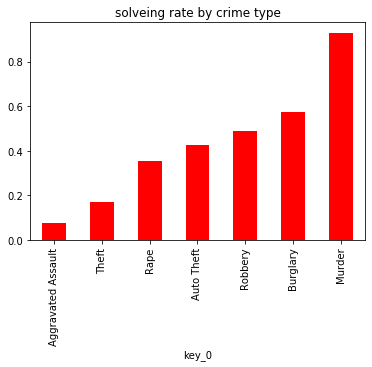

In [28]:
crime = pd.DataFrame(df['Category Description'].value_counts())

crime_sol = pd.DataFrame(df[df['Clearance Status'] != 'N']['Category Description'].value_counts())

crime_m = crime.merge(crime_sol, right_on=crime.index.values,
                      left_on=crime_sol.index.values, suffixes=['_all', '_solved'])

crime_m['solveing rate'] = crime_m['Category Description_solved']/crime_m['Category Description_all']

crime_m = crime_m.set_index('key_0') 

crime_m['solveing rate'].sort_values().plot(kind='bar', color='r', title = 'solveing rate by crime type')

# process data for ggplot

In [165]:
violent = ['Aggravated Assault', 'Murder', 'Rape']
df['Crime Type'] = 'non-violent'
df['Crime Type'][df['Category Description'].map(lambda x: x in violent)] = 'violent'

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [171]:
df['day of the month'] =df['Occurred Date'].map(lambda x: x.day)

In [172]:
df.groupby(by=['Occurred Date', 'Crime Type', 'day of the month'])['Incident Number'].count().reset_index().to_csv("crime_type.csv")

# crime distribution among a day

In [ ]:
df_18['Occurred Time'].plot(kind='hist',bins=24, title='Crime counts across the day')

# What kind of crime takes the longest to solve

In [3]:
df.columns

Index([u'Incident Number', u'Highest Offense Description',
       u'Highest Offense Code', u'Family Violence', u'Occurred Date Time',
       u'Occurred Date', u'Occurred Time', u'Report Date Time', u'Report Date',
       u'Report Time', u'Location Type', u'Address', u'Zip Code',
       u'Council District', u'APD Sector', u'Census Tract',
       u'Clearance Status', u'Clearance Date', u'UCR Category',
       u'Category Description', u'Latitude', u'Longitude', u'Location'],
      dtype='object')

# what ADP is the most efficient in solving cases?  7/30

In [4]:
df['Clearance Status'].value_counts()

N    315316
C     51380
O      9352
Name: Clearance Status, dtype: int64

In [25]:
df['Category Description'].value_counts()

Theft                 284163
Burglary               55270
Auto Theft             20372
Aggravated Assault     18847
Robbery                 9109
Rape                    6770
Murder                   285
Name: Category Description, dtype: int64

In [20]:
mask = (df['Clearance Status']=='C') | (df['Clearance Status']=='O')
df_cl = df[mask]

In [22]:
df_cl['Clearance Status'].value_counts()

C    51380
O     9352
Name: Clearance Status, dtype: int64

In [24]:
df_cl['Category Description'].value_counts()

Theft                 34309
Aggravated Assault    11039
Burglary               5947
Auto Theft             3223
Rape                   3149
Robbery                2825
Murder                  240
Name: Category Description, dtype: int64

In [49]:
df_cl['Time processing'] = (df_cl['Clearance Date'] - df_cl['Occurred Date']).map(lambda x: x.days)

C:\Users\spong\Anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
df_cl.pivot_table(index='APD Sector', 
                  columns='Category Description', 
                  values='Time processing', 
                 aggfunc=mean)

Category Description,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft
APD Sector,,,,,,,
88,16.600000,1.000000,11.000000,NaN,250.705882,181.000000,48.294118
AD,18.970896,32.466667,96.390295,15.071429,180.409091,43.990244,25.899370
AP,13.500000,56.285714,12.000000,NaN,NaN,0.000000,58.395604
BA,20.631485,29.979239,54.189236,69.750000,159.935115,65.516129,28.499335
CH,17.619275,30.838235,45.415693,133.967742,172.544304,62.006135,28.736182
DA,18.236842,35.882086,59.888747,68.722222,188.761610,65.113269,20.293088
ED,19.143902,23.001953,109.818280,32.954545,143.260628,54.518987,26.660417
FR,17.795141,32.775000,67.506448,124.000000,178.955157,51.290102,26.459116
GE,21.037094,23.367742,40.317597,110.529412,129.451389,29.767857,20.000530


In [52]:
df_cl['APD Sector'].value_counts()

DA    9333
ED    8818
ID    8491
FR    7209
HE    6943
AD    6262
CH    5160
BA    4895
GE    3306
AP     146
88      50
Name: APD Sector, dtype: int64

# clean data for RF prediction

In [55]:
df['Isocalendar'] = df['Occurred Date'].map(lambda x: x.isocalendar()[0:3])

In [6]:
df1 = df.groupby(by='Isocalendar')['Isocalendar'].count()

In [64]:
df2 = pd.DataFrame(df1)
df2.columns.values[0] = 'crime count'

df2['week of all data'] = range(0, df2.shape[0])
df2['Iso'] = df2.index.values
df2['week of the year'] = df2['Iso'].map(lambda x: x[1])
df2['year'] = df2['Iso'].map(lambda x: x[0])
df2.to_csv("data_for_bagging.csv")
train = df2[df2['year'] < 2019]
test = df2[df2['year'] >= 2019]

trainX = train[['week of all data', 'week of the year']].as_matrix()
trainY = train['crime count'].as_matrix()
print(len(trainY))

testX = test[['week of all data', 'week of the year']].as_matrix()
testY = test['crime count'].as_matrix()
print(len(testY))

In [17]:
from sklearn.ensemble import BaggingRegressor

In [45]:
regr = BaggingRegressor(n_estimators=1000, max_samples=300)
regr.fit(trainX, trainY)
pd.Series(regr.predict(trainX)).plot()
pd.Series(trainY).plot()
regr.score(trainX, trainY)

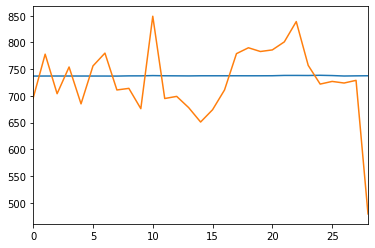

In [48]:
pd.Series(regr.predict(testX)).plot()
pd.Series(testY).plot()
regr.score(testX, testY)

# try daily prediction..

In [65]:
df3 = df.groupby(by='Occurred Date')['Occurred Date'].count()
df3.head()

Occurred Date
2010-01-01    162
2010-01-02    136
2010-01-03    113
2010-01-04    138
2010-01-05    118
Name: Occurred Date, dtype: int64

In [68]:
df2 = pd.DataFrame(df3)
df2.columns.values[0] = 'crime count'

df2['Iso'] = [x.isocalendar() for x in df2.index]
df2['day of all data'] = range(0, df2.shape[0])
df2['week of the year'] = df2['Iso'].map(lambda x: x[1])
df2['year'] = [x.year for x in df2.index]
df2['month'] = [x.month for x in df2.index]
df2['day of the month'] = [x.day for x in df2.index]
df2['week day'] = df2['Iso'].map(lambda x: x[2])
df2.to_csv("data_for_bagging_daily.csv")

df2.head()

,crime count,Iso,day of all data,week of the year,year,month,day of the month,week day
Occurred Date,,,,,,,,
2010-01-01,162,"(2009, 53, 5)",0,53,2010,1,1,5
2010-01-02,136,"(2009, 53, 6)",1,53,2010,1,2,6
2010-01-03,113,"(2009, 53, 7)",2,53,2010,1,3,7
2010-01-04,138,"(2010, 1, 1)",3,1,2010,1,4,1
2010-01-05,118,"(2010, 1, 2)",4,1,2010,1,5,2


In [71]:
train = df2[df2['year'] < 2019]
test = df2[df2['year'] >= 2019]

trainX = train.iloc[:,2:].as_matrix()
trainY = train['crime count'].as_matrix()
print(len(trainY))

testX = test.iloc[:,2:].as_matrix()
testY = test['crime count'].as_matrix()
print(len(testY))

3287
201


C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [92]:
import matplotlib
import matplotlib.pyplot as plt

0.6461916037035875

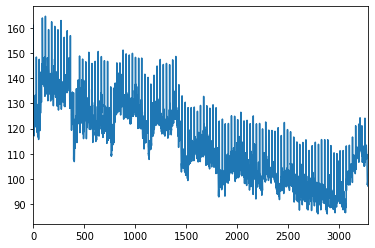

In [110]:
regr = BaggingRegressor(n_estimators=450, max_samples=450)
regr.fit(trainX, trainY)
pd.Series(regr.predict(trainX)).plot()
regr.score(trainX, trainY)

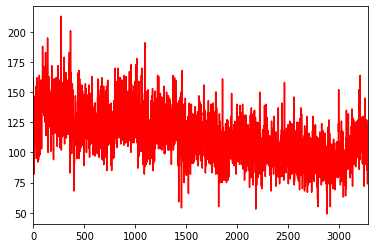

In [112]:
pd.Series(trainY).plot(color='r')

0.03007458634961102

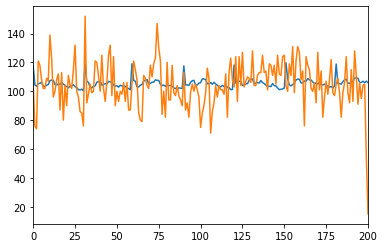

In [109]:
pd.Series(regr.predict(testX)).plot()
pd.Series(testY).plot()
regr.score(testX, testY)

# how max_samples affects score

In [97]:
train_score = list()
test_score = list()
for i in np.arange(100, 1050, 50):
    regr = BaggingRegressor(n_estimators=2000, max_samples=i)
    regr.fit(trainX, trainY)
    train_score.append(regr.score(trainX, trainY))
    test_score.append(regr.score(testX, testY))

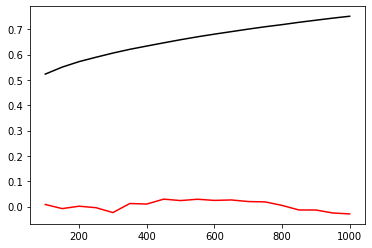

In [96]:
fig, ax = plt.subplots()
ax.plot(np.arange(100, 1050, 50), train_score, color = 'k')
ax.plot(np.arange(100, 1050, 50), test_score, color = 'r')

# how n_estmators affect scores?

In [100]:
%%time
train_score = list()
test_score = list()
for i in np.arange(50, 500, 50):
    regr = BaggingRegressor(n_estimators=i, max_samples=200)
    regr.fit(trainX, trainY)
    train_score.append(regr.score(trainX, trainY))
    test_score.append(regr.score(testX, testY))

Wall time: 2.89 s


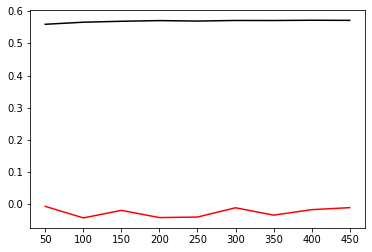

In [101]:
fig, ax = plt.subplots()
ax.plot(np.arange(50, 500, 50), train_score, color = 'k')
ax.plot(np.arange(50, 500, 50), test_score, color = 'r')

In [ ]:
from sklearn import RandomForestClassifier
